In [1]:
%matplotlib inline
import xlrd
import operator
import math
import re
import nltk
import scipy
import random
import openpyxl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import networkx as nx
from functools import reduce
import seaborn as sns
from pactools.grid_search import GridSearchCVProgressBar
from collections import Counter, defaultdict
from itertools import chain, product
from decimal import Decimal
from ast import literal_eval
from tqdm import tqdm

# Sklearn imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

pd.options.mode.chained_assignment = None

tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
stemmer = nltk.stem.snowball.SnowballStemmer("dutch")

In [2]:
# Importing data
def importdata(file):
    df = pd.read_csv(file, index_col=0)
    df = df.loc[df['speech category'] == 'Main Speech']
    return df 
df = importdata("HandelingenRutte2.csv")
df['stemmed_text'] = df.text.apply(lambda x: ' '.join([stemmer.stem(t) for t in tokenizer.tokenize(x)]))
df['normal_text'] = df.text.apply(lambda x: ' '.join([t.lower() for t in tokenizer.tokenize(x)]))
df.drop(columns=['tags'])
df.head(5)

,surname,party,text,file,speech category,date,tags,titel,stemmed_text,normal_text
175881,Wilders,PVV,\r\n \r\n Mevrouw de voo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,mevrouw de voorzitter dit kabinet heeft ons mo...,mevrouw de voorzitter dit kabinet heeft ons mo...
175882,Roemer,SP,\r\n \r\n Voorzitter. Vo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter vorig wek plaatst werkgever werknem...,voorzitter vorige week plaatsten werkgevers we...
175883,Pechtold,D66,\r\n \r\n Voorzitter. Tw...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter twee maand geled kreg dit kabinet v...,voorzitter twee maanden geleden kreeg dit kabi...
175884,Van Haersma Buma,CDA,\r\n \r\n Voorzitter. Al...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter allen al in de eerst drie maand van...,voorzitter alleen al in de eerste drie maanden...
175889,Thieme,PvdD,\r\n \r\n Voorzitter. We...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter we zijn eruit eerst ontdekt de mini...,voorzitter we zijn eruit eerst ontdekte de min...


# Data Info

803.9600230083405 444.0


c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


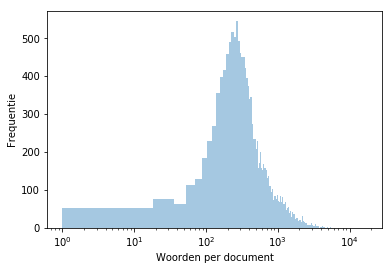

In [3]:
#leaving out all that is outside 95%
list_text = df.stemmed_text.apply(lambda x: x.split(" "))
t = [len(doc) for doc in list_text]
print(np.mean(t),np.median(t))
fit =scipy.stats.lognorm.fit(t)
ax = sns.distplot(t,bins=1000,norm_hist=False,kde=False)
ax.set_xscale('log')
ax.set(xlabel='Woorden per document', ylabel='Frequentie')
plt.savefig("Verslag/Tables/lengthtextslog.png")

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


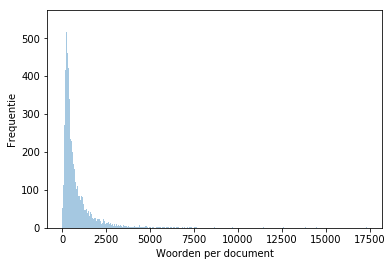

In [4]:
ax = sns.distplot(t, bins=1000, norm_hist=False,kde=False)
ax.set(xlabel='Woorden per document', ylabel='Frequentie')
plt.savefig("Verslag/Tables/lengthtexts.png")

In [5]:
df = df.loc[df.stemmed_text.apply(lambda x: len(x.split(' '))) < math.exp(fit[0]+2*fit[1])]
df = df.loc[df.stemmed_text.apply(lambda x: len(x.split(' '))) > math.exp(fit[0]-2*fit[1])]
list_text = df.stemmed_text.apply(lambda x: x.split(" "))
print("Ondergrens:",math.exp(fit[0]+2*fit[1]),"\nBovengrens:",math.exp(fit[0]-2*fit[1]))
print("Mediaan",np.median([len(doc) for doc in list_text]),"\nGemiddelde",np.mean([len(doc) for doc in list_text]))
print("Overgebleven documenten:",len(df))

Ondergrens: 1492.675589876518 
Bovengrens: 27.339307082607387
Mediaan 386.0 
Gemiddelde 498.18961004094234
Overgebleven documenten: 14899


In [6]:
len(df.file.unique())

2984

In [7]:
#https://stackoverflow.com/questions/11350770/pandas-dataframe-select-by-partial-string

# Creates a dataframe with counts of dataset per party
countdf = pd.concat([df.party.value_counts(),df[df['titel'].str.contains("Vragen van het lid")].party.value_counts(), df[~df['titel'].str.contains("Vragen van het lid")].party.value_counts()], axis=1)
countdf.columns = ['Totaal', 'Vragenuur','Debat']
countdf = countdf.sort_values("Totaal",axis=0, ascending=False)
with open("Verslag/Tables/Spreekbeurten.tex", "w") as f:
    f.write(countdf.to_latex(header=True))
countdf = countdf.sort_index()
countdf

,Totaal,Vragenuur,Debat
50PLUS,387,12,375
CDA,1901,88,1813
ChristenUnie,1068,32,1036
D66,1889,133,1756
GroenLinks,1068,47,1021
PVV,1700,49,1651
PvdA,1821,112,1709
PvdD,432,14,418
SGP,655,10,645
SP,2284,107,2177


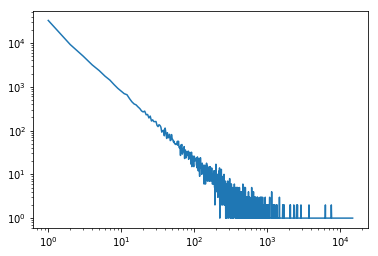

In [8]:
tekst = chain.from_iterable([list(set(doc)) for doc in list_text])
del list_text
count = Counter(tekst)
samples = list(count.values())
t = Counter(samples)
t = sorted(t.items())
x, y = zip(*t)
plt.loglog(x, y)
plt.show()

# Baseline

In [9]:
simpleprediction = np.random.choice(countdf.index, len(df.party), p = [x/countdf["Totaal"].sum() for x in list(countdf['Totaal'])])
print(classification_report(df.party, simpleprediction))
print("Accuracy:",accuracy_score(df.party, np.full(len(df.party), countdf["Totaal"].idxmax())))

              precision    recall  f1-score   support

      50PLUS       0.03      0.03      0.03       387
         CDA       0.12      0.12      0.12      1901
ChristenUnie       0.06      0.07      0.06      1068
         D66       0.12      0.12      0.12      1889
  GroenLinks       0.06      0.07      0.07      1068
         PVV       0.12      0.12      0.12      1700
        PvdA       0.13      0.12      0.12      1821
        PvdD       0.03      0.03      0.03       432
         SGP       0.03      0.03      0.03       655
          SP       0.15      0.16      0.15      2284
         VVD       0.12      0.11      0.12      1694

 avg / total       0.11      0.11      0.11     14899

Accuracy: 0.15329887911940399


# Models

In [10]:
def modelsdownload(file,only_doen=False):
    models_df = pd.read_excel(file, index_col=0)
    if only_doen:
        models_df = models_df.loc[models_df.DOEN == True]
    models_dict = {}
    for x,y in zip(models_df.Classifier, models_df.PIPELINE):
        exec(compile("a="+y,'','exec'), globals())
        models_dict[x] = Pipeline(a)
    return models_df, models_dict

In [11]:
models_df, models_dict = modelsdownload('Models.xlsx',True)

# Creates a dict with parameters per classifier   
params_dict = {}
for clf in set(models_df.Classifier):
    params_df = models_df.loc[models_df.Classifier == clf]
    params_df = params_df.loc[params_df.DOEN == True]
    params_df = params_df.dropna(axis=1, how='all')
    params_df = params_df.drop([col for col in params_df.columns if "__" not in col], axis=1)
    temp_dict = {}
    for x, y in params_df.to_dict(orient='list').items():
        a = literal_eval(y[0])
        temp_dict[x] = a
    params_dict[clf] = temp_dict
    
text_dict = {x:y for x, y in zip(models_df.Classifier, models_df.STEMMED)}


In [12]:
scoring = ['accuracy', 'f1_weighted', 'precision_weighted','recall_weighted']
for name, pipe in models_dict.items():
    print("Bezig: %s" %name)
    text = df.stemmed_text if text_dict[name] else df.normal_text
        
    gs = GridSearchCVProgressBar(pipe, params_dict[name], cv=5, scoring=scoring, refit = False, return_train_score = False, n_jobs=-1)
    gs.fit(text, df.party)
    rows = pd.DataFrame(gs.cv_results_)
    # https://stackoverflow.com/questions/38231591/splitting-dictionary-list-inside-a-pandas-column-into-separate-columns
    rows = pd.concat([rows.drop(['params'], axis=1), rows['params'].apply(pd.Series)], axis=1)
    rows["name"] = name 
    rows["stemmed"] = text_dict[name]
    pd.concat([rows, pd.read_excel('Scores.xlsx', index_col=0)], ignore_index=True).sort_values(['mean_test_f1_weighted'], ascending=False).to_excel('Scores.xlsx')
    df4 = pd.read_excel('Models.xlsx', index_col=0)
    df4.loc[df4.Classifier == name, "DOEN"] = False
    df4.to_excel('Models.xlsx')
    print("Voltooid: %s" %name)
    
# https://stackoverflow.com/questions/46735847/save-best-params-in-gridsearch-in-a-pandas-dataframe
# https://stackoverflow.com/questions/36271413/pandas-merge-nearly-duplicate-rows-based-on-column-value?rq=1

# Best Score

In [13]:
#source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('Echte klasse')
    plt.xlabel('Voorspelde klasse')

In [14]:
# https://stackoverflow.com/questions/39662398/scikit-learn-output-metrics-classification-report-into-csv-tab-delimited-format
def classification_report_csv(real,predicted):
    report = classification_report(real, predicted)
    report_data = []
    lines = report.split('\n')
    for line in lines[0:-1]:
        row = {}
        row_data = line.split('     ')
        if len(row_data)<5:
            continue
        row['Partij'] = row_data[-5].replace(" ","")
        row['Precision'] = float(row_data[-4])
        row['Recall'] = float(row_data[-3])
        row['F1 score'] = float(row_data[-2])
        row['Documenten'] = int(row_data[-1])
        report_data.append(row)
    df = pd.DataFrame.from_dict(report_data)
    df = df.reindex(["Partij","Precision","Recall",'F1 score',"Documenten"], axis=1).set_index('Partij')
    as_list = df.index.tolist()
    idx = as_list.index('avg/total')
    as_list[idx] = 'Totaal'
    df.index = as_list
    return df

In [15]:
# Select the classifier and parameters with highest score
def getbestpipe(file):
    scores = pd.read_excel(file, index_col=0).sort_values(['mean_test_f1_weighted'], ascending=False).head(1)
    scores = scores.dropna(axis=1).reset_index(drop=True)
    scores.vect__ngram_range[0] = literal_eval(scores.vect__ngram_range[0])
    models_df, models_dict = modelsdownload('Models.xlsx',False)
    text_dict = {x:y for x, y in zip(models_df.Classifier, models_df.STEMMED)}
    pipe = models_dict[scores.name[0]]
    params = scores.drop([col for col in scores.columns if "__" not in col or "param" in col], axis=1).to_dict(orient='records')[0]
    params['vect__min_df'] = int(params['vect__min_df'])
    pipe.set_params(**params)
    stem = text_dict[scores.name[0]]
    return pipe, stem

In [16]:
def traintest3(pipe, text, data, save=False):
    train, test = train_test_split(data, test_size=0.2)
    pipe.fit(train[text], train.party)
    predicted = pipe.predict(test[text])
    report = classification_report_csv(test.party, predicted)
    accuracy = accuracy_score(test.party, predicted)
    cnf_matrix = confusion_matrix(test.party, predicted)
    indices = np.where(test.party != predicted)
    indices = test.iloc[indices].index.values
    return [pipe, cnf_matrix, report, accuracy, indices]
    

def traintest(file, data, save=False, params=None, stemmed="stemmed_text",normal="normal_text"):
    n=5
    base_pipe, stem = getbestpipe(file)
    if params!=None:
        base_pipe.set_params(**params)
    text = stemmed if stem else normal
    pipelist, cnflist, reportlist, accuracylist, indiceslist = zip(*[traintest3(base_pipe, text, data, save=False) for x in tqdm(range(n))])
    accuracy = np.mean(accuracylist)
    cnf_matrix = np.mean(cnflist, axis=0)
    #https://stackoverflow.com/questions/45983321/sum-a-list-of-pandas-dataframes?rq=1
    report = reduce(lambda x, y: x.add(y, fill_value=0), reportlist)
    nlist =Counter(chain.from_iterable([x[x['F1 score']!=0.0].index.values for x in reportlist]))
    report = report.divide(pd.Series(nlist),axis=0)
    report=report.round(2)
    report.Documenten = report.Documenten.round(0).astype(int)
    print(report)
    print(accuracy)
    plt.figure(figsize=(10, 10))
    plot_confusion_matrix(cnf_matrix.astype(int), \
                      classes=sorted(list(data.party.unique())), \
                      title='Confusion matrix best estimator')
    if save:
        plt.savefig("Verslag/Tables/%s.png" %save)
        with open("Verslag/Tables/%s.tex" %save, "w") as f:
            f.write(report.to_latex())

    plt.show()
    return pipelist[0], indiceslist

In [17]:
def mostimportantwords(pipe, countdf, filename=None):
    vocab = pipe.named_steps['vect'].vocabulary_
    inv_vocab = {v: k for k, v in vocab.items()}
    coefs = pipe.named_steps[[x for x in pipe.named_steps.keys() if not x=='vect'][0]].coef_
    top_words = [[inv_vocab[t] for t in coefs[i].argsort()[-100:][::-1]] for i in range(coefs.shape[0])]
    top_words = pd.DataFrame(top_words).T
    top_words.columns = countdf.index
    if filename!=None:
        with open("Verslag/Tables/%s1.tex" %filename, "w", encoding='utf-8') as f:
            f.write(top_words.iloc[:,:5].head(10).to_latex(index=False))
        with open("Verslag/Tables/%s2.tex" %filename, "w", encoding='utf-8') as f:
            f.write(top_words.iloc[:,5:].head(10).to_latex(index=False))
        top_words.to_excel("%s.xlsx" %filename)
        
    return top_words.head(10)

In [ ]:
pipe, indiceslist = traintest('Scores.xlsx', df ,save="confusionmatrix",params= {'SGD__max_iter':100})
mostimportantwords(pipe, countdf, filename='MostImportantWords')

# What went wrong

In [ ]:
missclassdocs = df.loc[chain.from_iterable(indiceslist)]
np.mean([len(doc) for doc in missclassdocs.stemmed_text.apply(lambda x: x.split(" "))])
np.median([len(doc) for doc in missclassdocs.stemmed_text.apply(lambda x: x.split(" "))])
fig, ax = plt.subplots()
for a,l in [(missclassdocs.stemmed_text.apply(lambda x:len(x.split(" "))),'Verkeerd geclassificeerde documenten'), ((df.stemmed_text.apply(lambda x:len(x.split(" ")))),'Alle documenten')]:
    sns.distplot(a, kde=True, norm_hist=True, label=l, axlabel='Woorden per document')
plt.legend()
plt.savefig("Verslag/Tables/misclassifiedlengths.png")
plt.show()
print(np.median([len(doc) for doc in missclassdocs.stemmed_text.apply(lambda x: x.split(" "))]))

In [ ]:
print(len(df[df['titel'].str.contains("Vragen van het lid")])/len(df))
print(len(missclassdocs[missclassdocs['titel'].str.contains("Vragen van het lid")])/len(missclassdocs))
print(np.median([len(doc) for doc in df[df['titel'].str.contains("Vragen van het lid")].stemmed_text.apply(lambda x: x.split(" "))]))


In [ ]:
falsedocs = pd.concat([missclassdocs.groupby('surname').party.count(),df.groupby('surname').party.count(),missclassdocs.groupby('surname').party.count()/df.groupby('surname').party.count() ], axis=1)
falsedocs.to_excel('False.xlsx')
falsedocs.columns = ['a','b','c']
falsedocs.fillna(0,inplace=True)
ax = sns.regplot(x=falsedocs.b, y=falsedocs.c)
ax.set(xlabel = 'Totaal aantal documenten', ylabel = 'Misclassificaties / Totaal aantal documenten')
plt.savefig("Verslag/Tables/misclassifiedsprekers.png")
scipy.stats.pearsonr(falsedocs.b, falsedocs.c)

# Without Names

In [18]:
Party_synomyns = ["Partij van de Arbeid","Socialistische Partij","Partij voor de Dieren","Volkspartij voor Vrijheid en Democratie","Partij voor de Vrijheid"]
partijnamen = list(df.party.unique()) + Party_synomyns
partijnamen += ["[Hh]et "+ x for x in partijnamen] + ["[Dd]e "+ x for x in partijnamen]
partijnamen = re.compile('|'.join(partijnamen))
kamerlidnamen = re.compile('|'.join(df.surname.unique()) + "|Dijkstra|Van Dijk|Van Nieuwenhuizen|Baay|Berndsen|Jansen|Günal|Schut|Nijkerken|Buma|Venrooy|Mulder|De Vries|Berckmoes|Van Dijck|Pia")
temp = df.text.apply(lambda x: re.sub(kamerlidnamen,"xxxxx",re.sub(partijnamen,"yyyyy",x)).lower())
df['stemmed_withoutnames'] = temp.apply(lambda x: ' '.join([stemmer.stem(t).replace("xxxxx",'KAMERLID').replace("yyyyy", 'PARTIJ') for t in tokenizer.tokenize(x)]))
df['normal_withoutnames'] = temp.apply(lambda x: ' '.join([t.replace("xxxxx",'KAMERLID').replace("yyyyy", 'PARTIJ') for t in tokenizer.tokenize(x)]))
del temp

In [ ]:
pipe, indiceslist = traintest('Scores.xlsx', df, save="withoutnames",params= {'SGD__max_iter':100}, stemmed='stemmed_withoutnames', normal='normal_withoutnames')
mostimportantwords(pipe, countdf, filename='MostImportantWordsWithoutNames')

# Only Names

In [ ]:
partijnamen = list(df.party.unique()) + Party_synomyns
partijnamen = re.compile('|'.join(partijnamen))
df["names"] = df.text.apply(lambda x: re.findall(partijnamen, x)+re.findall(kamerlidnamen, x))
df["names"] = df.names.apply(lambda x: ' '.join([y.replace(" ", "") for y in x]).lower())
df.head(5)

In [ ]:
pipe, indiceslist = traintest('Scores.xlsx', df, save = "onlynames", params= {'vect__ngram_range':(1,1),'SGD__max_iter':100}, stemmed='names', normal='names')

In [ ]:
mostimportantwords(pipe, countdf, filename='onlynames')

# Confusion matrix analyse

In [ ]:
G = nx.Graph()
G.add_edges_from([(8,10), (10,1),(1,5),(5,2),(2,3),(3,0),(0,7),(7,6),(6,4),(4,9)])
F = nx.Graph()
F.add_weighted_edges_from([(8,10,3.971), (10,1,4.928),(1,5,2.059),(5,2,5.439),(2,3,10.981),(3,0,5.533),(0,7,0.154),(7,6,0.093),(6,4,3.026),(4,9,11.342)])

In [ ]:
def traintest2(file, data, save=False,params=None,stemmed="stemmed_text",normal="normal_text"):
    train, test = data
    pipe, stem = getbestpipe(file)
    if params!=None:
        pipe.set_params(**params)
    text = stemmed if stem else normal
    pipe.fit(train[text], train.party)
    predicted = pipe.predict(test[text])
    cm = confusion_matrix(test.party, predicted)
    tot = len(predicted)
    ggg = defaultdict(int)
    ideology = defaultdict(list)
    ideologyw = defaultdict(list)
    mix = []
    regering = []
    oppositie = []
    for i in range(cm.shape[0]):
        for j in range(cm.shape[0]):
            if i!=j:
                a = (sum(cm[i,:])-cm[i,i]) * (sum(cm[j,:])/(tot-sum(cm[i,:])))
                ggg[(i,sum(cm[i,:]))]+=a
                if i in [6,10] and j in [6,10]:
                    regering.append(cm[i,j]-a)
                elif i in [0,1,2,3,4,5,7,8,9] and j in [0,1,2,3,4,5,7,8,9]:
                    oppositie.append(cm[i,j]-a)
                else:
                    mix.append(cm[i,j]-a)
                ideology[nx.shortest_path_length(G,i,j)].append(cm[i,j]-a)
                ideologyw[nx.dijkstra_path_length(F,i,j)].append(cm[i,j]-a)
    return pipe, oppositie, regering, mix, ggg, ideology,ideologyw

In [ ]:
o = []
m = []
r = []
g = {}
ideology2 = []
ideology3 = []
for i in tqdm(range(100)):
    pipe, oppositie, regering, mix, ggg, ideology, ideologyw =traintest2('Scores.xlsx', train_test_split(df, test_size=0.2),params= {'SGD__max_iter':100}, stemmed='stemmed_withoutnames', normal='normal_withoutnames')
    g ={**g, **ggg}
    o.append(oppositie)
    r.append(regering)
    m.append(mix)
    ideology2.append(ideology)
    ideology3.append(ideologyw)

In [ ]:
ideology = []
for i in ideology3:
    for j,k in i.items():
        for l in k:
            ideology.append((j,l))

ideology = pd.DataFrame(ideology, columns=['distance','error'])
oppositielist = []
for i in [0,1,2,3,4,5,7,8,9]:
    for j in [0,1,2,3,4,5,7,8,9]:
        oppositielist.append(nx.dijkstra_path_length(F,i,j))
def status(x):
    if x in oppositielist:
        return 'Binnen opppositie'
    elif x==29.187:
        return 'Binnen regering'
    else:
        return 'Tussen oppositie en regering'
ideology['Partij-status'] = ideology.distance.apply(lambda x: status(x))
q= sns.lmplot(x='distance', y='error', hue='Partij-status', data=ideology,fit_reg=False, palette=sns.color_palette("Blues", 3))
ax = sns.regplot(ideology.distance, ideology.error, scatter=False, ax=q.axes[0, 0])
ax.set(xlabel = 'Afstand op links/rechts schaal', ylabel = 'Misclassificaties / Totaal aantal documenten')
fig = ax.get_figure()
fig.savefig('Verslag/Tables/Ideology.png')
print("totaal:",scipy.stats.pearsonr(ideology.distance,ideology.error))
print("oppositie:",scipy.stats.pearsonr(ideology.loc[ideology['Partij-status'] == 'Binnen opppositie'].distance,ideology.loc[ideology['Partij-status'] == 'Binnen opppositie'].error))
print("mixed:",scipy.stats.pearsonr(ideology.loc[ideology['Partij-status'] == 'Tussen oppositie en regering'].distance,ideology.loc[ideology['Partij-status'] == 'Tussen oppositie en regering'].error))

In [ ]:
(keys,values) = zip(*g.items())
party, keys = zip(*keys)
keys = pd.Series(keys,name='false negatives + true positives')
values = pd.Series(values,name='false positives')
party = pd.Series(party,name="Partij").replace(dict(enumerate(sorted(df.party.unique()))))
q = sns.lmplot(x='false negatives + true positives', y='false positives', hue='Partij', data=pd.concat([keys, values, party], axis=1),fit_reg=False, palette=sns.color_palette("hls", 11))
ax = sns.regplot(keys, values, scatter=False, ax=q.axes[0, 0])
fig = ax.get_figure()
fig.savefig('Verslag/Tables/Correlation.png') 
scipy.stats.pearsonr(keys,values)

In [ ]:
# Dit gebruiken
ax = sns.distplot(list(chain.from_iterable(o)),kde=True)
ax.set(xlabel = 'Error')
fig = ax.get_figure()
fig.savefig('Verslag/Tables/Oppositie.png') 
print("Mean:",np.mean(list(chain.from_iterable(o))))
print(scipy.stats.normaltest(list(chain.from_iterable((o-np.mean(o))/np.std(o)))))

In [ ]:
ax = sns.distplot(list(chain.from_iterable(r)),kde=True)
ax.set(xlabel = 'Error')
fig = ax.get_figure()
fig.savefig('Verslag/Tables/Regering.png') 
np.mean(list(chain.from_iterable(r)))
print(scipy.stats.normaltest(list(chain.from_iterable((r-np.mean(r))/np.std(r)))))

In [ ]:
ax = sns.distplot(list(chain.from_iterable(m)),kde=True)
ax.set(xlabel = 'Error')
fig = ax.get_figure()
fig.savefig('Verslag/Tables/Mix.png') 
np.mean(list(chain.from_iterable(m)))
print(scipy.stats.normaltest(list(chain.from_iterable((m-np.mean(m))/np.std(m)))))

In [ ]:
ax = sns.distplot(list(chain.from_iterable(m+o+r)),kde=True)
ax.set(xlabel = 'Error')
fig = ax.get_figure()
fig.savefig('Verslag/Tables/Totaal.png')
print(np.mean(list(chain.from_iterable(m+o+r))))
print(scipy.stats.normaltest(((list(chain.from_iterable(m+o+r)))-np.mean(list(chain.from_iterable(m+o+r))))/np.std(list(chain.from_iterable(m+o+r)))))

In [ ]:
# https://stackoverflow.com/questions/15984221/how-to-perform-two-sample-one-tailed-t-test-with-numpy-scipy
print("R:", scipy.stats.mannwhitneyu(list(chain.from_iterable(r)),list(chain.from_iterable(m)),alternative='greater'))
print("O:", scipy.stats.mannwhitneyu(list(chain.from_iterable(o)),list(chain.from_iterable(m)),alternative='greater'))


# Woorden Balkenende 4

In [ ]:
# Importing data
dfb4 = importdata("HandelingenBalkenende4.csv")
dfb4['stemmed_text'] = dfb4.text.apply(lambda x: ' '.join([stemmer.stem(t) for t in tokenizer.tokenize(x)]))
dfb4 = dfb4.loc[dfb4.stemmed_text.apply(lambda x: len(x.split(' '))) < math.exp(fit[0]+2*fit[1])]
dfb4 = dfb4.loc[dfb4.stemmed_text.apply(lambda x: len(x.split(' '))) > math.exp(fit[0]-2*fit[1])]

In [ ]:
# Creates a dataframe with counts of dataset per party
countdfb4 = pd.concat([dfb4.party.value_counts(),dfb4[dfb4['titel'].str.contains("Vragen van het lid")].party.value_counts(), dfb4[~dfb4['titel'].str.contains("Vragen van het lid")].party.value_counts()], axis=1)
countdfb4.columns = ['Totaal', 'Vragenuur','Debat']
countdfb4 = countdfb4.sort_values("Totaal",axis=0, ascending=False)
countdfb4 = countdfb4.sort_index()
with open("Verslag/Tables/SpreekbeurtenBal.tex", "w") as f:
    f.write(countdfb4.to_latex(header=True))
countdfb4

In [ ]:
simpleprediction = np.random.choice(countdfb4.index, len(dfb4.party), p = [x/countdfb4["Totaal"].sum() for x in list(countdfb4['Totaal'])])
print(classification_report(dfb4.party, simpleprediction))
print("Accuracy:",accuracy_score(dfb4.party, np.full(len(dfb4.party), countdfb4["Totaal"].idxmax())))

In [ ]:
Party_synomyns = ["Partij van de Arbeid","Socialistische Partij","Partij voor de Dieren","Volkspartij voor Vrijheid en Democratie","Partij voor de Vrijheid"]
partijnamen = list(dfb4.party.unique()) + Party_synomyns
partijnamen += ["[Hh]et "+ x for x in partijnamen] + ["[Dd]e "+ x for x in partijnamen]
partijnamen = re.compile('|'.join(partijnamen))
kamerlidnamen = re.compile('|'.join(dfb4.surname.unique())+"|Kortenhorst|Wiegman|De Roos|Schreijer|Willemse|Snijder|Van Vroonhoven|Dezentjé Hamming|Blanksma|Buma|De Pater|Ortega|Madsen")
temp = dfb4.text.apply(lambda x: re.sub(kamerlidnamen,"xxxxx",re.sub(partijnamen,"yyyyy",x)).lower())
dfb4['stemmed_withoutnames'] = temp.apply(lambda x: ' '.join([stemmer.stem(t).replace("xxxxx",'KAMERLID').replace("yyyyy", 'PARTIJ').replace("KAMERLIDman", "timmerman") for t in tokenizer.tokenize(x)]))
dfb4['normal_withoutnames'] = temp.apply(lambda x: ' '.join([t.replace("xxxxx",'KAMERLID').replace("yyyyy", 'PARTIJ').replace("KAMERLIDman", "timmerman") for t in tokenizer.tokenize(x)]))

In [ ]:
pipe, indiceslist = traintest('Scores.xlsx', dfb4, normal = 'normal_withoutnames', stemmed='stemmed_withoutnames',params= {'SGD__max_iter':100})

In [ ]:
mostimportantwords(pipe, countdfb4, 'WoordenBalkenende4')

In [ ]:
pipe, indiceslist = traintest('Scores.xlsx', df[df.party != '50PLUS'],params= {'SGD__max_iter':100}, stemmed='stemmed_withoutnames', normal='normal_withoutnames')

In [ ]:
# Creates a dataframe with counts of dataset per party
dfz5 = df[df.party != '50PLUS']
countdfz5 = pd.concat([dfz5.party.value_counts(),dfz5[dfz5['titel'].str.contains("Vragen van het lid")].party.value_counts(), dfz5[~dfz5['titel'].str.contains("Vragen van het lid")].party.value_counts()], axis=1)
countdfz5.columns = ['Totaal', 'Vragenuur','Debat']
countdfz5 = countdfz5.sort_values("Totaal",axis=0, ascending=False)
countdfz5 = countdfz5.sort_index()
countdfb4

In [ ]:
simpleprediction = np.random.choice(countdfz5.index, len(dfz5.party), p = [x/countdfz5["Totaal"].sum() for x in list(countdfz5['Totaal'])])
print(classification_report(dfz5.party, simpleprediction))
print("Accuracy:",accuracy_score(dfz5.party, np.full(len(dfz5.party), countdfz5["Totaal"].idxmax())))

# Vergelijken

In [ ]:
def traintest5(file, data, save=False, stemmed="stemmed_text",normal="normal_text",params=None):
    pipe, stem = getbestpipe(file)
    if params!=None:
        pipe.set_params(**params)
    train, test = data
    text = stemmed if stem else normal
    pipe.fit(train[text], train.party)
    predicted = pipe.predict(test[text])
    report = classification_report_csv(test.party, predicted)
    print(report)
    print(accuracy_score(test.party, predicted))
    cnf_matrix = confusion_matrix(test.party, predicted)
    plt.figure(figsize=(10, 10))
    plot_confusion_matrix(cnf_matrix.astype(int), \
                      classes=sorted(list(train.party.unique())), \
                      title='Confusion matrix best estimator')
    if save:
        plt.savefig("Verslag/Tables/%s.png" %save)
        with open("Verslag/Tables/%s.tex" %save, "w") as f:
            f.write(report.to_latex())
    return pipe

In [ ]:
pipe = traintest5('Scores.xlsx', (df[df.party != '50PLUS'],dfb4), save="RutToBal", stemmed="stemmed_withoutnames", normal="normal_withoutnames",params= {'SGD__max_iter':100})

In [ ]:
pipe = traintest5('Scores.xlsx', (dfb4,df[df.party != '50PLUS']), save="BalToRut", stemmed="stemmed_withoutnames", normal="normal_withoutnames",params= {'SGD__max_iter':100})

In [ ]:
woordenBalk = pd.read_excel('WoordenBalkenende4.xlsx', index_col=0)
woordenRut = pd.read_excel('MostImportantWordsWithoutNames.xlsx', index_col=0)
commondict = defaultdict(dict)
for partyB in ["PvdA", "ChristenUnie", "CDA"]:
    for partyR in ["VVD", "PvdA"]:
        commondict[partyB][partyR] = [x for x in set(woordenBalk[partyB])&set(woordenRut[partyR]) - set(woordenBalk[partyR]) - set(woordenRut[partyB])]
commondict

In [ ]:
oppositiewoorden = woordenBalk.drop(["PvdA", "ChristenUnie", "CDA"], axis=1).values.flatten()
pointlesswords = ["in","men","de"]
for partyB in ["PvdA","CDA", "ChristenUnie"]:
    for partyR in ["PvdA", "ChristenUnie", "CDA"]:
        if partyR!=partyB:
            for word in woordenBalk[partyR]:
                for word2 in woordenBalk[partyB]:
                    if word in word2 and word not in pointlesswords and word2 not in pointlesswords and word not in oppositiewoorden and word2 not in oppositiewoorden:
                        #print(partyB, "->",partyR,":",word,",", word2)
                        continue

In [ ]:
oppositiewoorden = woordenRut.drop(['VVD', 'PvdA'], axis=1).values.flatten()
for partyB in ["PvdA", "VVD"]:
    for partyR in ["VVD", "PvdA"]:
        if partyR!=partyB:
            for word in woordenRut[partyR]:
                for word2 in woordenRut[partyB]:
                    if word in word2 and word not in ["en","in","men"] and word2 not in ["en","in","men"] and word not in oppositiewoorden and word2 not in oppositiewoorden:
                        print(partyB, "->",partyR,":",word,",", word2)

# Taalgebruik van sprekers

In [19]:
def traintest3(pipe, text, data, save=False):
    trainsprekers, testsprekers = train_test_split(data.surname.unique(), test_size=0.2)
    train = data[data['surname'].isin(trainsprekers)]
    test = data[data['surname'].isin(testsprekers)]
     
    pipe.fit(train[text], train.party)
    predicted = pipe.predict(test[text])
    report = classification_report_csv(test.party, predicted)
    accuracy = accuracy_score(test.party, predicted)
    cnf_matrix = confusion_matrix(test.party, predicted)
    indices = np.where(test.party != predicted)
    indices = test.iloc[indices].index.values
    return pipe, cnf_matrix, report, accuracy, indices
    

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
 20%|████████████████▌                                                                  | 1/5 [04:00<16:02, 240.72s/it]c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
 60%|█████████████████████████████████████████████████▊                                 | 3/5 [11:56<07:57, 238.85s/it]c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1137: Undef

              Precision  Recall  F1 score  Documenten
50PLUS             0.73    0.14      0.22         178
CDA                0.10    0.24      0.13         192
ChristenUnie       0.12    0.10      0.08         247
D66                0.26    0.23      0.22         426
GroenLinks         0.34    0.03      0.05         485
PVV                0.39    0.52      0.40         323
PvdA               0.23    0.18      0.18         428
PvdD               0.63    0.28      0.32         169
SGP                0.31    0.10      0.15         190
SP                 0.15    0.47      0.20         284
Totaal             0.32    0.20      0.20        3014
VVD                0.27    0.25      0.25         357
0.20351635497948478


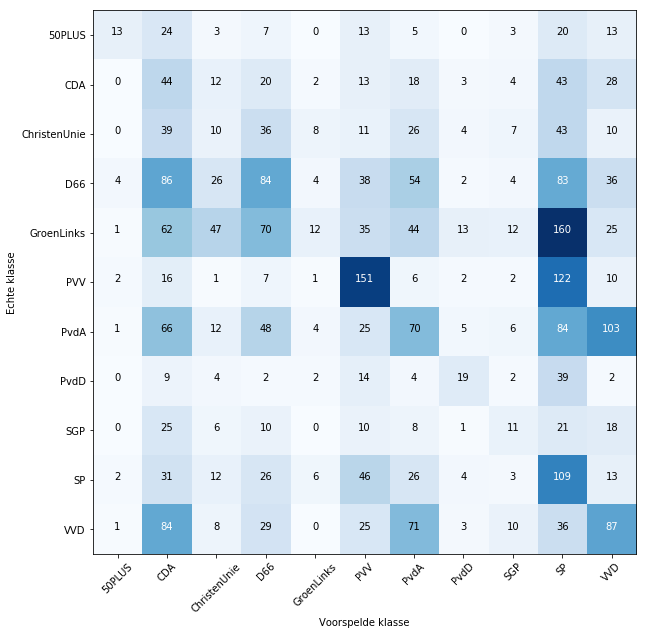

,50PLUS,CDA,ChristenUnie,D66,GroenLinks,PVV,PvdA,PvdD,SGP,SP,VVD
0,ouderen,PARTIJ fractie,vluchtelingen,mijn fractie,kamer hierover te,islamitische,en,dieren,beantwoording,zegt,volgens mij
1,gepensioneerden,inwoners,mensenhandel,mijn,schone,miljard,jongeren,natuur,mevrouw de voorzitter,mening dat,aruba
2,koopkrachtontwikkeling,PARTIJ,19637,natuurlijk,schone energie,islam,sociale,milieu,mevrouw de,van mening dat,PARTIJ fractie
3,werkenden,regering,kinderen,het kabinet,hierover te,de islam,kinderen,constaterende,punt,bezuinigingen,aangegeven
4,oudere,wij,rechtsstaat,belangrijk,hierover te informeren,nederland,wij,constaterende dat,voor de beantwoording,bestuurders,essentieel
5,overwegende,echt,zullen,kabinet,zou,al,mijn,bio,bewindslieden,van mening,uwv
6,overwegende dat,de regering,inderdaad,daarom,in elk geval,natuurlijk,blij,de bio,de beantwoording,mening,speelveld
7,PARTIJ,hier,gezinnen,fractie,elk geval,miljarden,de regering tevens,bio industrie,op,huurders,daadwerkelijk
8,voor gepensioneerden,fractie,inmiddels,vandaag,in elk,beraadslaging verzoekt,regering tevens,industrie,nadrukkelijk,de bevolking,beantwoording
9,mevrouw de voorzitter,uiteindelijk,christenen,minister,regering om,de beraadslaging verzoekt,tevens,aarde,allereerst,voorstellen,ao


In [20]:
pipe, indiceslist = traintest('Scores.xlsx', df ,save="taalgebruik", stemmed='stemmed_withoutnames', normal='normal_withoutnames',params= {'SGD__max_iter':100})
mostimportantwords(pipe, countdf, 'taalgebruik')